
🔎 Found files:
 - RAVDESS: 1440
 - TESS: 5600
 - TOTAL: 7040
✅ Data shape: (3872, 128, 128, 1)
✅ Labels: ['angry' 'happy' 'neutral' 'sad']



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 6

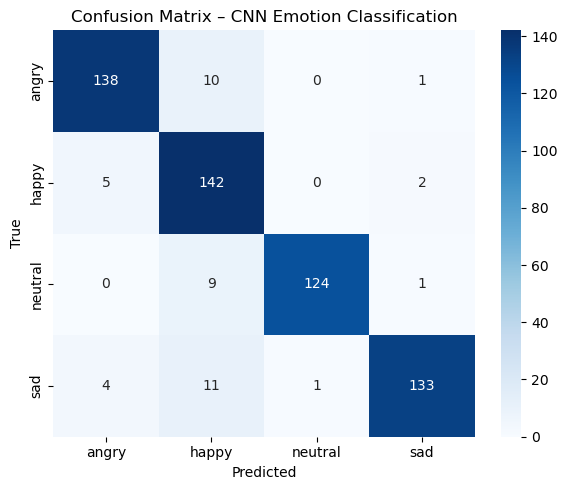

✅ Model saved successfully!


In [1]:
# ==========================
# Deep Learning Emotion Recognition
# ==========================
import os
import glob
import warnings
import numpy as np
import librosa
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import datetime

warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------
# PATHS
# -------------------------------
RAVDESS_PATH = r"C:\Users\DELL\Downloads\archive (10)\Actor_*/*.wav"
TESS_PATH = r"C:\Users\DELL\Downloads\archive (11)\TESS Toronto emotional speech set data\**\*.wav"
ALLOWED_EMOTIONS = {'neutral', 'happy', 'sad', 'angry'}

# -------------------------------
# EMOTION LABEL EXTRACTION
# -------------------------------
def get_emotion_label(file_path):
    file_name = os.path.basename(file_path).lower()
    folder_name = os.path.dirname(file_path).lower()

    if "actor" in folder_name:
        code = file_name.split("-")[2]
        emotion_map = {
            "01": "neutral",
            "02": "calm",
            "03": "happy",
            "04": "sad",
            "05": "angry",
            "06": "fearful",
            "07": "disgust",
            "08": "surprised"
        }
        return emotion_map.get(code, "unknown")
    elif "tess" in folder_name:
        for emo in ["angry", "happy", "neutral", "sad"]:
            if emo in file_name:
                return emo
    return "unknown"

# -------------------------------
# FEATURE EXTRACTION (Mel-spectrogram)
# -------------------------------
def extract_mel_spectrogram(file_path, sr=16000, n_mels=128):
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_db

# -------------------------------
# DATA LOADING
# -------------------------------
ravdess_files = glob.glob(RAVDESS_PATH, recursive=True)
tess_files = glob.glob(TESS_PATH, recursive=True)
all_files = ravdess_files + tess_files

print("🔎 Found files:")
print(" - RAVDESS:", len(ravdess_files))
print(" - TESS:", len(tess_files))
print(" - TOTAL:", len(all_files))

X, y = [], []
for file in all_files:
    label = get_emotion_label(file)
    if label not in ALLOWED_EMOTIONS:
        continue
    try:
        mel = extract_mel_spectrogram(file)
        # Resize or pad to fixed length for consistency
        if mel.shape[1] < 128:
            mel = np.pad(mel, ((0,0),(0,128 - mel.shape[1])), mode='constant')
        else:
            mel = mel[:, :128]
        X.append(mel)
        y.append(label)
    except Exception as e:
        print(f"⚠️ Skipping {file}: {e}")

X = np.array(X)
X = X[..., np.newaxis]  # (samples, n_mels, time, 1)
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(le.classes_)

print("✅ Data shape:", X.shape)
print("✅ Labels:", le.classes_)

# -------------------------------
# SPLIT DATA
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# -------------------------------
# BUILD CNN MODEL
# -------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------------------
# TRAIN
# -------------------------------
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=30,
    batch_size=32
)

# -------------------------------
# EVALUATE
# -------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\n🏁 Final Test Accuracy: {test_acc:.3f}")

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – CNN Emotion Classification")
plt.tight_layout()
plt.show()

# -------------------------------
# SAVE MODEL
# -------------------------------
os.makedirs("models", exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
model.save(f"models/emotion_cnn_model_{timestamp}.h5")
print("✅ Model saved successfully!")


In [3]:
# ==========================
# Emotion Recognition – Inference from Saved CNN Model
# ==========================
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

import joblib
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# CONFIGURATION
# -------------------------------
MODEL_PATH = r"models\emotion_cnn_model_20251010_0105.h5"  # 👈 change this if needed
ALLOWED_EMOTIONS = ['neutral', 'happy', 'sad', 'angry']
N_MELS = 128
FIXED_TIME_STEPS = 128  # same as used during training

# -------------------------------
# LOAD MODEL + LABEL ENCODER
# -------------------------------
print(f"✅ Loaded model from: {MODEL_PATH}")
model = load_model(MODEL_PATH)

# You must use the same label encoder classes as used during training
# If you didn’t save it earlier, manually recreate it as below:
le = LabelEncoder()
le.fit(ALLOWED_EMOTIONS)  # Ensure same order as training

# -------------------------------
# FEATURE EXTRACTION FUNCTION
# -------------------------------
def extract_mel_spectrogram(file_path, sr=16000, n_mels=N_MELS):
    """
    Convert a .wav file into a normalized Mel-spectrogram array
    matching the model's expected input size.
    """
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Pad or trim to ensure consistent shape
    if mel_db.shape[1] < FIXED_TIME_STEPS:
        mel_db = np.pad(mel_db, ((0,0),(0, FIXED_TIME_STEPS - mel_db.shape[1])), mode='constant')
    else:
        mel_db = mel_db[:, :FIXED_TIME_STEPS]
    
    mel_db = mel_db[..., np.newaxis]  # (n_mels, time, 1)
    return mel_db

# -------------------------------
# PREDICTION FUNCTION
# -------------------------------
def predict_emotion_from_file(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    mel = extract_mel_spectrogram(file_path)
    X = np.expand_dims(mel, axis=0)  # (1, 128, 128, 1)
    
    preds = model.predict(X)
    pred_idx = np.argmax(preds)
    emotion_label = le.classes_[pred_idx]
    confidence = float(np.max(preds)) * 100
    
    print("\n🎵 File:", os.path.basename(file_path))
    print(f"Predicted Emotion: {emotion_label} ({confidence:.2f}% confidence)")
    return emotion_label, confidence

# -------------------------------
# EXAMPLE USAGE
# -------------------------------
sample_file = r"C:\Users\DELL\Downloads\1001_ITS_SAD_XX.wav"  # 👈 replace with your test .wav file
predict_emotion_from_file(sample_file)


✅ Loaded model from: models\emotion_cnn_model_20251010_0105.h5
1/1 [==============================] - 0s 140ms/step

🎵 File: 1001_ITS_SAD_XX.wav
Predicted Emotion: sad (99.84% confidence)


('sad', 99.83794689178467)

In [36]:
# =========================================
# 🎙️ Real-Time Speech Emotion Recognition – CNN
# =========================================
import os
import librosa
import numpy as np
import sounddevice as sd
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# CONFIGURATION
# -------------------------------
MODEL_PATH = r"models\emotion_cnn_model_20251010_0105.h5"  # ✅ Change if your model filename differs
ALLOWED_EMOTIONS = ['neutral', 'happy', 'sad', 'angry']     # Same as during training
SAMPLE_RATE = 16000
N_MELS = 128
FIXED_TIME_STEPS = 128

# -------------------------------
# LOAD MODEL + LABEL ENCODER
# -------------------------------
print(f"✅ Loading model from: {MODEL_PATH}")
model = load_model(MODEL_PATH)
le = LabelEncoder()
le.fit(ALLOWED_EMOTIONS)

# -------------------------------
# FEATURE EXTRACTION (Mel-Spectrogram)
# -------------------------------
def extract_mel_spectrogram(file_path, sr=SAMPLE_RATE, n_mels=N_MELS):
    """
    Converts a .wav file to Mel-spectrogram (normalized and padded)
    matching model's input shape.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr, mono=True)
        if len(y) < 2048:
            print("⚠️ Audio too short for feature extraction.")
            return None
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Pad or trim to fixed size (128x128)
        if mel_db.shape[1] < FIXED_TIME_STEPS:
            mel_db = np.pad(mel_db, ((0,0),(0, FIXED_TIME_STEPS - mel_db.shape[1])), mode='constant')
        else:
            mel_db = mel_db[:, :FIXED_TIME_STEPS]
        
        mel_db = mel_db[..., np.newaxis]  # (128, 128, 1)
        return mel_db
    except Exception as e:
        print(f"❌ Error extracting features: {e}")
        return None

# -------------------------------
# PREDICTION FUNCTION
# -------------------------------
def predict_emotion_from_file(file_path):
    if not os.path.exists(file_path):
        print("❌ File not found:", file_path)
        return

    features = extract_mel_spectrogram(file_path)
    if features is None:
        print("⚠️ Could not extract features.")
        return

    X = np.expand_dims(features, axis=0)  # (1, 128, 128, 1)
    preds = model.predict(X)
    pred_idx = np.argmax(preds)
    emotion = le.classes_[pred_idx]
    confidence = float(np.max(preds)) * 100

    print("\n🎵 File:", os.path.basename(file_path))
    print(f"🎯 Predicted Emotion: {emotion} ({confidence:.2f}% confidence)")
    return emotion, confidence

# -------------------------------
# RECORD AND PREDICT LIVE AUDIO
# -------------------------------
def record_and_predict(duration=4, sr=SAMPLE_RATE):
    print(f"\n🎤 Recording for {duration}s... Speak now!")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()
    sf.write("live.wav", audio, sr)
    print("✅ Saved recording as 'live.wav'")
    predict_emotion_from_file("live.wav")

# -------------------------------
# MAIN PROGRAM
# -------------------------------
if __name__ == "__main__":
    print("""
==== 🎙️ CNN-BASED SPEECH EMOTION PREDICTION ====
Recording voice and predicting emotion...
""")
    record_and_predict()


✅ Loading model from: models\emotion_cnn_model_20251010_0105.h5

==== 🎙️ CNN-BASED SPEECH EMOTION PREDICTION ====
Recording voice and predicting emotion...


🎤 Recording for 4s... Speak now!
✅ Saved recording as 'live.wav'
1/1 [==============================] - 0s 120ms/step

🎵 File: live.wav
🎯 Predicted Emotion: happy (82.57% confidence)
